<a href="https://colab.research.google.com/github/dealtron/Mall-Clustering/blob/master/Mall_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Data Science Course - Telkom Digital Talent Incubator*


---




# **Clustering**

Analisis clustering atau clustering adalah proses pengelompokan sejumlah data yang kemudian akan ditempatkan dalam beberapa grup (atau cluster) jika mempunyai kesamaan, dan dibedakan dengan grup (clusters) lainnya.

Dan disini saya akan mencoba untuk melakukan clustering terhadap data yang telah disediakan, yaitu Mall_Customers.csv. Disini saya akan mencoba untuk membagi beberapa Customer menjadi beberapa grup/segment (clusters) berdasarkan data yang ada dan berpengaruh.

### **Import Libraries**

Pertama-tama, disini saya akan mengimport library terlebih dahulu.

In [206]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

### **Import Raw Dataset**

Lalu disini saya akan mencoba untuk melihat seperti apakah data yang akan saya gunakan untuk proses clustering ini.

In [207]:
# Import Dataset
df_mall = pd.read_csv('https://raw.githubusercontent.com/dealtron/Mall-Clustering/master/data/Mall_Customers.csv')
df_mall

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


Seperti yang kita lihat, Mall_Customers.csv mempunyai beberapa attributes, yaitu :
1. CustomerID (1-200),
2. Gender (Male, Female),
3. Age (18-70),
4. Annual Income (k$) (15-137),
5. Spending Score (1-100) (1-99),

Lalu disini saya akan melihat perbandingan ada berapa customer pada setiap atribute di dataset yang telah disediakan

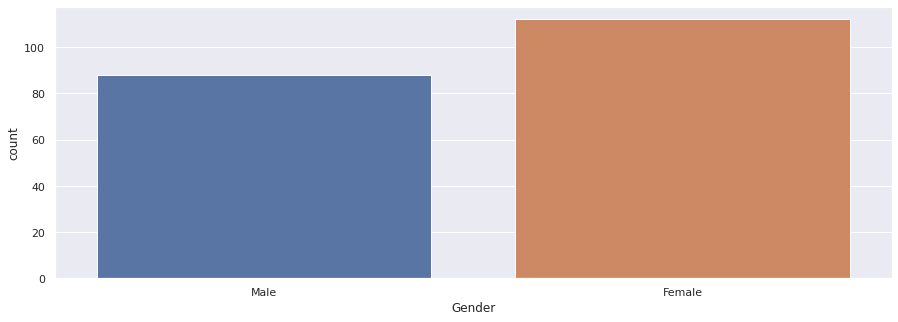

In [208]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(x = 'Gender' , data = df_mall)
plt.show()

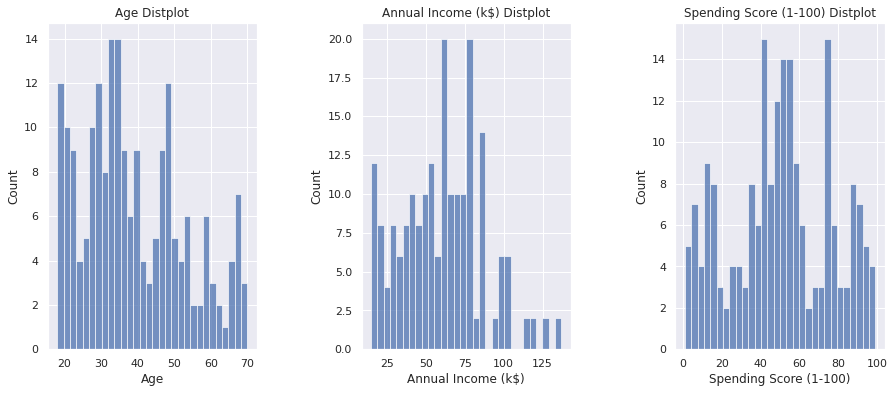

In [209]:
plt.figure(1 , figsize = (15 , 6))
another = ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']
n = 0 
for x in another :
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.histplot(df_mall[x], bins = 30)
    plt.title('{} Distplot'.format(x))
plt.show()

Kemudian saya akan mengecek apakah dataset kita mempunyai data null atau tidak

In [210]:
df_mall.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [211]:
# Prints the Dataset Information
df_mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Seperti yang kita lihat, tidak ada data kosong pada dataset ini.

Pada proses clustering, CustomerID tidak terlalu berguna. Maka, akan lebih baik kita mendropnya terlebih dahulu.

In [212]:
feature = df_mall.drop(['CustomerID'], axis=1)

Dan berikut ini adalah statistical descriptive pada setiap atribute yang ada (kecuali Gender).

In [213]:
# Prints Descriptive Statistics
feature.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


### **Data Preprocessing**

Pertama-tama, saya akan melakukan standard scaler terlebih dahulu, agar data semakin nyaman untuk diolah dan tidak mempunyai rentang nilai terlalu besar.

In [214]:
# Importing Standardscalar Module 
from sklearn.preprocessing import StandardScaler 

# Set Name for StandardScaler as scaler
scaler = StandardScaler() 

# Fit Standardization
column_names = feature.columns.tolist()
column_names.remove('Gender')
feature[column_names] = scaler.fit_transform(feature[column_names])
feature.sort_index(inplace=True)
feature

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,-1.424569,-1.738999,-0.434801
1,Male,-1.281035,-1.738999,1.195704
2,Female,-1.352802,-1.700830,-1.715913
3,Female,-1.137502,-1.700830,1.040418
4,Female,-0.563369,-1.662660,-0.395980
...,...,...,...,...
195,Female,-0.276302,2.268791,1.118061
196,Female,0.441365,2.497807,-0.861839
197,Male,-0.491602,2.497807,0.923953
198,Male,-0.491602,2.917671,-1.250054


Lalu disini saya tidak akan memakai semua features. Disini saya hanya akan memakai Age, Annual Income (k$), dan Spending Score (1-100). Untuk gender akan saya drop, dan kemudian kita akan membuat beberapa scenario, yaitu :

1. Age dan Annual Income (k$),

2. Age dan Spending Score (1-100),

3. Annual Income (k$) dan Spending Score (1-100),

4. Age, Annual Income (k$), dan Spending Score (1-100).

In [215]:
features = feature.drop(['Gender'], axis=1)
features_ai = features.drop(['Spending Score (1-100)'], axis=1)
features_as = features.drop(['Annual Income (k$)'], axis=1)
feautres_is = features.drop(['Age'], axis=1)

### **Data Visualization**

Disini saya akan memvisualisasikan scenario Annual Income (k$) dan Spending Score (1-100)

Text(0, 0.5, 'Spending Score (1-100)')

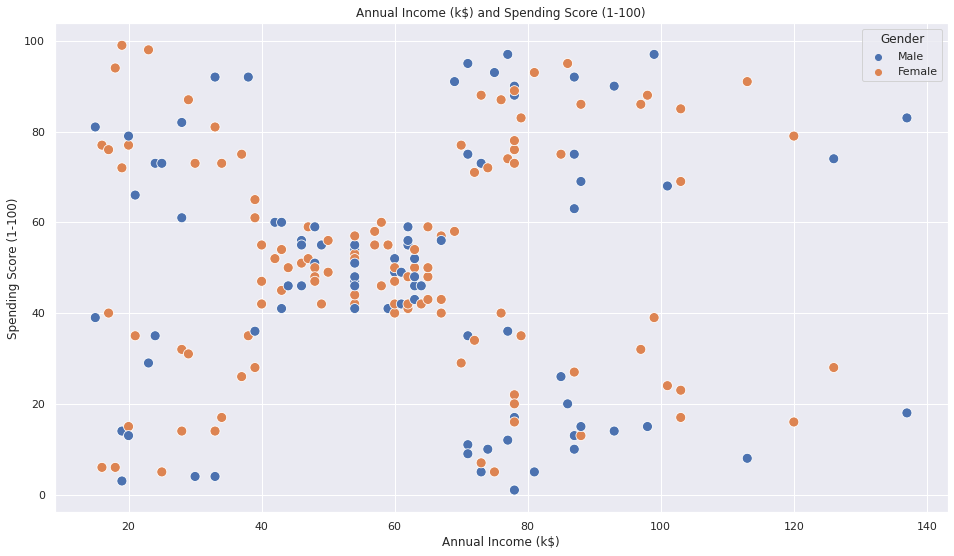

In [216]:
# Styling Plot
sns.set()
plt.rcParams['figure.figsize'] = (16, 9)

# Visualizing the Data
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', data=df_mall,s=100)
plt.title('Annual Income (k$) and Spending Score (1-100)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

Data Visualization dari Age dan Annual Income (k$)

Text(0, 0.5, 'Annual Income (k$)')

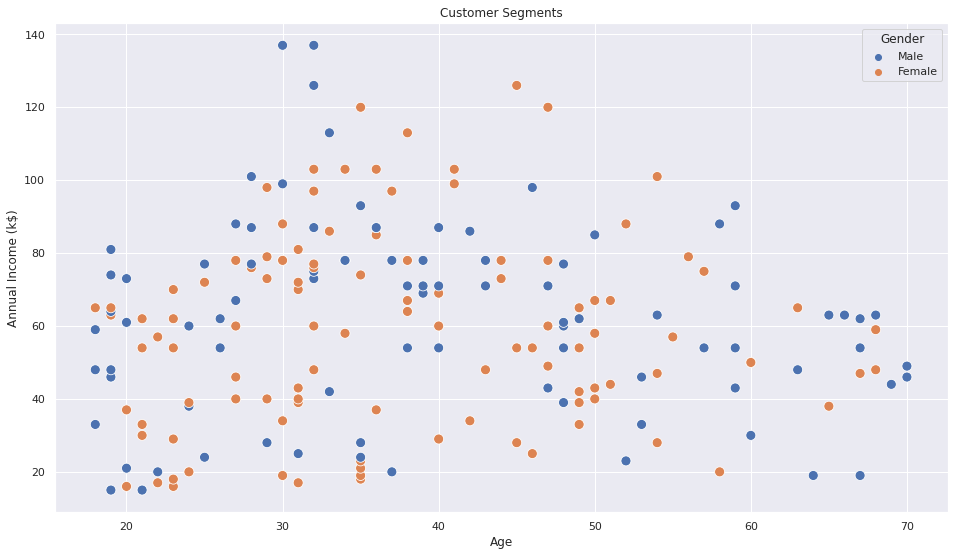

In [217]:
# Styling Plot
sns.set()
plt.rcParams['figure.figsize'] = (16, 9)

# Visualizing the Data
sns.scatterplot(x='Age', y='Annual Income (k$)', hue='Gender', data=df_mall,s=100)
plt.title('Customer Segments')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')

Data Visualization dari Age dan Spending Score (1-100),

Text(0, 0.5, 'Spending Score (1-100)')

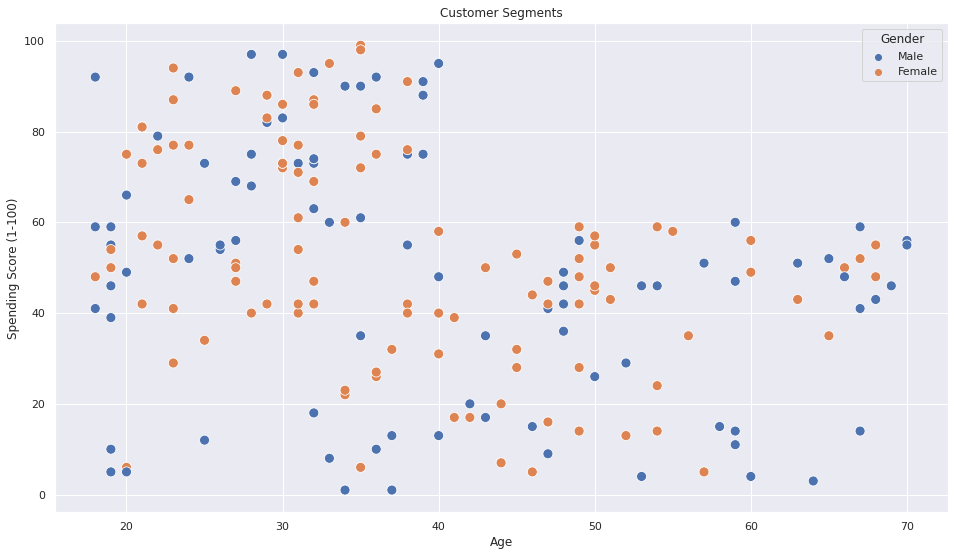

In [218]:
# Styling Plot
sns.set()
plt.rcParams['figure.figsize'] = (16, 9)

# Visualizing the Data
sns.scatterplot(x='Age', y='Spending Score (1-100)', hue='Gender', data=df_mall, s=100)
plt.title('Customer Segments')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')

Dan data visualization dari Age, Annual Income (k$), dan Spending Score (1-100)

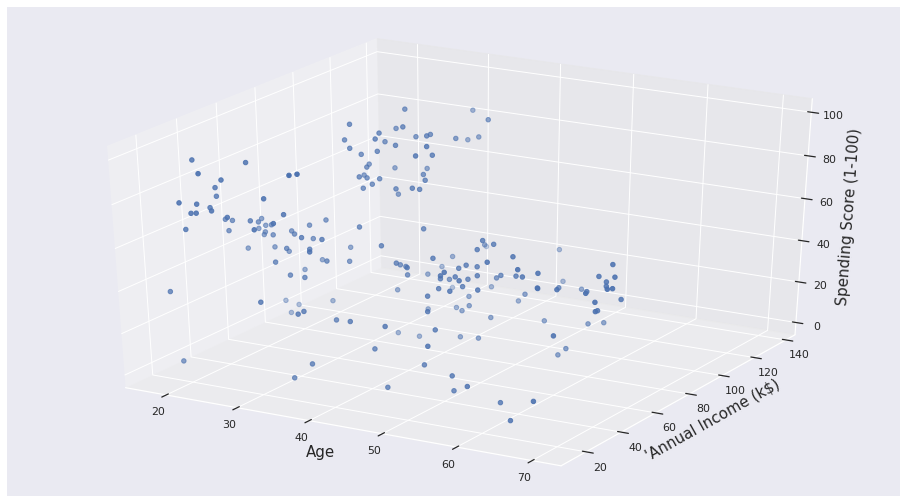

In [219]:
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_mall['Age'], df_mall['Annual Income (k$)'], df_mall['Spending Score (1-100)'], s=20)
ax.set_xlabel("Age",fontsize=15)
ax.set_ylabel("'Annual Income (k$)",fontsize=15)
ax.set_zlabel('Spending Score (1-100)',fontsize=15)
ax.view_init()
plt.show()

Setelah melihat visualisasi data dari beberapa skenario, disini saya akan mencoba untuk melakukan analisis menggunakan 2 skenario saja, yaitu :


1.   Annual Income (k$) dan Spending Score (1-100),

2.   Age, Annual Income (k$), dan Spending Score (1-100).



## **K-Means Clustering**

Kmeans algorithm is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the inter-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.

### **Search for the Optimum Number of Clusters (k)**

**Skenario 1 = Annual Income (k$) dan Spending Score (1-100)**

Disini saya akan mencoba elbow method terlebih untuk mencari nilai K optimum untuk analisis K-Means.

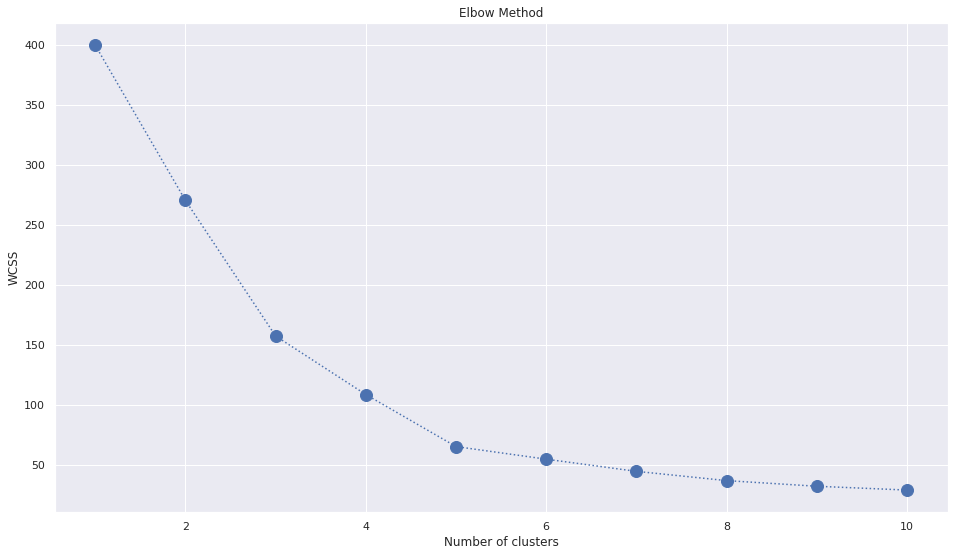

In [220]:
# Transform Data Frame to Numpy Array
income = feautres_is.to_numpy()
income

# Elbow Method
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(income)
    wcss.append(kmeans.inertia_)
  
# Visualize 
plt.plot(range(1,11),wcss,'o:',markersize=12)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Berdasarkan visualisasi elbow method yang telah dilakukan, nilai K terbaik berada di **K = 5**.

Lalu disini kita akan mencoba Silhouette Method.

In [221]:
# Silhoutte Method
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil_coeffs = []
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(income)
    label = kmeans.labels_
    sil_coeff = silhouette_score(income, label, metric='euclidean')
    sil_coeffs.append(sil_coeff)
    print('Di n_clusters={}, Silhouette Coefficient-nya adalah {}'.format(n_cluster, sil_coeff))

Di n_clusters=2, Silhouette Coefficient-nya adalah 0.29512063001659344
Di n_clusters=3, Silhouette Coefficient-nya adalah 0.46658474419000145
Di n_clusters=4, Silhouette Coefficient-nya adalah 0.4939069237513199
Di n_clusters=5, Silhouette Coefficient-nya adalah 0.5546571631111091
Di n_clusters=6, Silhouette Coefficient-nya adalah 0.5380630705007141
Di n_clusters=7, Silhouette Coefficient-nya adalah 0.5281492781108291
Di n_clusters=8, Silhouette Coefficient-nya adalah 0.45322124132447333
Di n_clusters=9, Silhouette Coefficient-nya adalah 0.4570853966942764
Di n_clusters=10, Silhouette Coefficient-nya adalah 0.44747842317664344


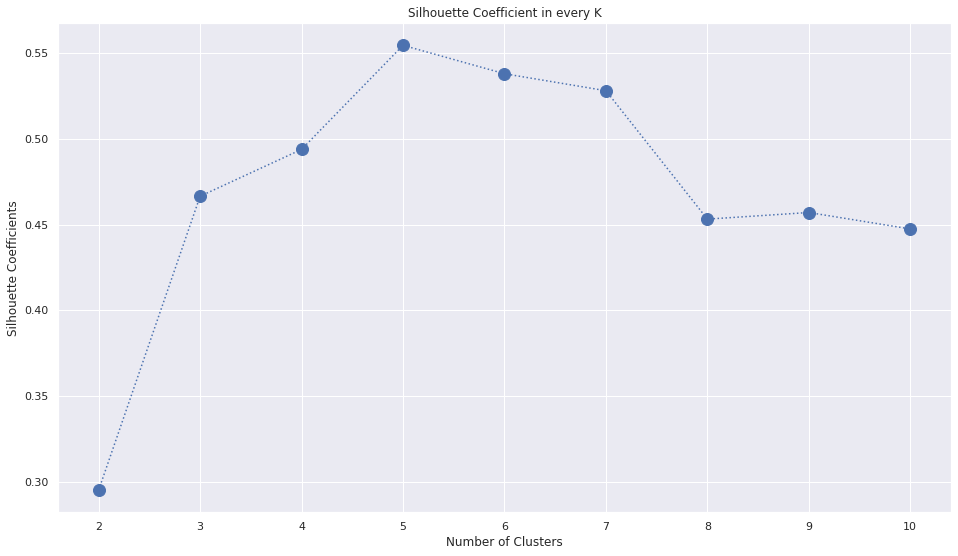

In [222]:
plt.plot(range(2,11),sil_coeffs,'o:',markersize=12)
plt.title("Silhouette Coefficient in every K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficients")
plt.show()

Berdasarkan visualisasi dan data Silhouette method yang telah dilakukan, nilai K terbaik berada di **K = 5** juga.

Maka dapat disimpulkan pada **skenario 1** ini, saya akan menggunakan nilai **K = 5**.

**Skenario 2 = Age, Annual Income (k$), dan Spending Score (1-100)**

Disini saya akan mencoba elbow method terlebih untuk mencari nilai K optimum untuk analisis K-Means.

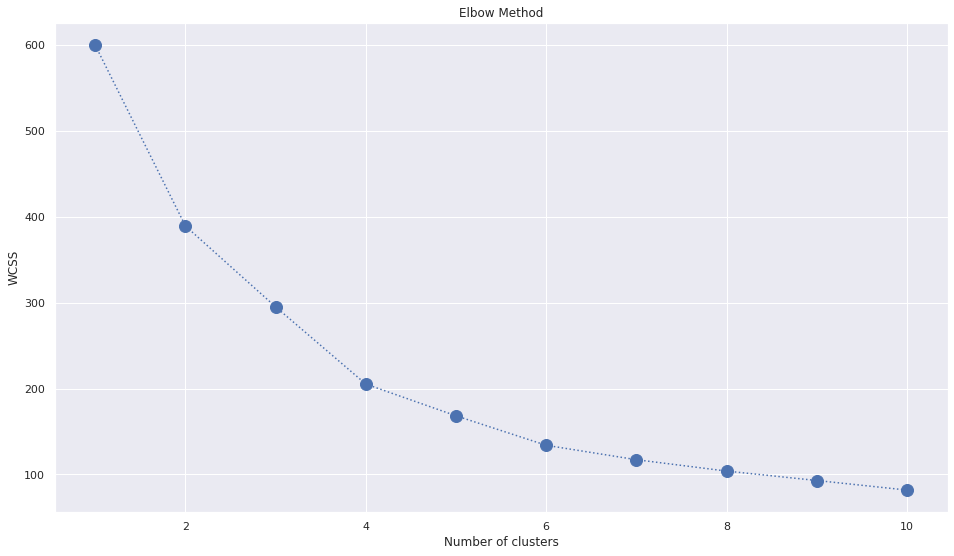

In [223]:
# Transform Data Frame to Numpy Array
ftrs = features.to_numpy()
ftrs

# Elbow Method
from sklearn.cluster import KMeans
wcss_3d = []
for i in range(1,11):
    kmeans_3d = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans_3d.fit(ftrs)
    wcss_3d.append(kmeans_3d.inertia_)

# Visualize 
plt.plot(range(1,11),wcss_3d,'o:',markersize=12)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Berdasarkan visualisasi elbow method yang telah dilakukan, nilai K terbaik berada di **K = 6**.

Lalu disini kita akan mencoba Silhouette Method.

In [224]:
# Silhoutte Method
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil_coeffs_3d = []
for n_cluster in range(2, 11):
    kmeans_3d = KMeans(n_clusters=n_cluster).fit(ftrs)
    label = kmeans_3d.labels_
    sil_coeff_3d = silhouette_score(ftrs, label, metric='euclidean')
    sil_coeffs_3d.append(sil_coeff_3d)
    print('Di n_clusters={}, Silhouette Coefficient-nya adalah {}'.format(n_cluster, sil_coeff_3d))

Di n_clusters=2, Silhouette Coefficient-nya adalah 0.33547192894004574
Di n_clusters=3, Silhouette Coefficient-nya adalah 0.3589575717698723
Di n_clusters=4, Silhouette Coefficient-nya adalah 0.4039582785148566
Di n_clusters=5, Silhouette Coefficient-nya adalah 0.41664341513732767
Di n_clusters=6, Silhouette Coefficient-nya adalah 0.4284167762892593
Di n_clusters=7, Silhouette Coefficient-nya adalah 0.417231894954916
Di n_clusters=8, Silhouette Coefficient-nya adalah 0.4100960228678141
Di n_clusters=9, Silhouette Coefficient-nya adalah 0.4216705265449019
Di n_clusters=10, Silhouette Coefficient-nya adalah 0.4274005537085155


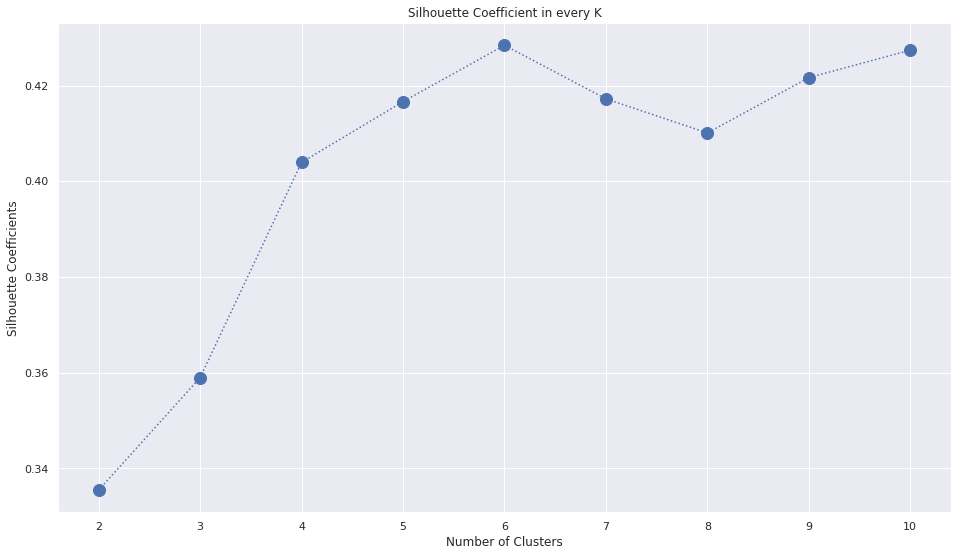

In [225]:
plt.plot(range(2,11),sil_coeffs_3d,'o:',markersize=12)
plt.title("Silhouette Coefficient in every K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficients")
plt.show()

Berdasarkan visualisasi dan data Silhouette method yang telah dilakukan, nilai K terbaik berada di **K = 6** juga.

Maka dapat disimpulkan pada **skenario 2** ini, saya akan menggunakan nilai **K = 5**.

### **Modeling K-Means**

**Skenario 1**

Disini saya akan mencoba memvisualisasikan data dari skenario 1 saya dengan Clustering K-Means yang telah dilakukan.

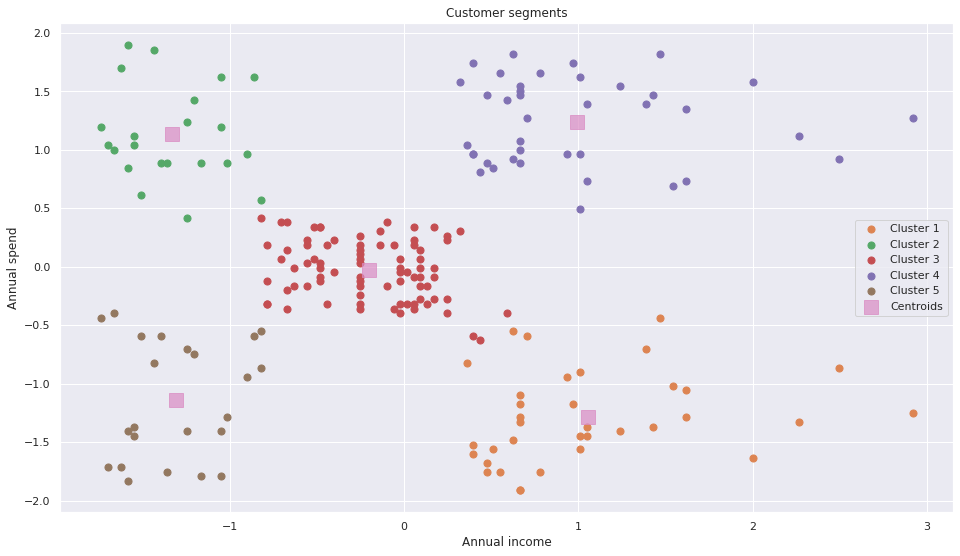

In [226]:
# Apply the K-Means Model to the Data
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster = kmeans.fit_predict(income)

# Visualising Clusters for k=5
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=feautres_is)
plt.scatter(income[cluster == 0, 0], income[cluster == 0, 1], s = 50, label = 'Cluster 1')
plt.scatter(income[cluster == 1, 0], income[cluster == 1, 1], s = 50, label = 'Cluster 2')
plt.scatter(income[cluster == 2, 0], income[cluster == 2, 1], s = 50, label = 'Cluster 3')
plt.scatter(income[cluster == 3, 0], income[cluster == 3, 1], s = 50, label = 'Cluster 4')
plt.scatter(income[cluster == 4, 0], income[cluster == 4, 1], s = 50, label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],s=200,marker='s', alpha=0.7, label='Centroids')
plt.title('Customer segments')
plt.xlabel('Annual income')
plt.ylabel('Annual spend')
plt.legend()
plt.show()

Dan disini saya juga memasukkan informasi cluster ke dalam raw data yang sebelumnya saya olah untuk mendapatkan K-Means Clustering.

In [227]:
# Add Cluster Information to the Raw Data
df_mall['cluster_skenario_1'] = cluster+1
df_mall

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster_skenario_1
0,1,Male,19,15,39,5
1,2,Male,21,15,81,2
2,3,Female,20,16,6,5
3,4,Female,23,16,77,2
4,5,Female,31,17,40,5
...,...,...,...,...,...,...
195,196,Female,35,120,79,4
196,197,Female,45,126,28,1
197,198,Male,32,126,74,4
198,199,Male,32,137,18,1


**Skenario 2**

Disini saya memasukkan informasi cluster dari skenario 2 ke dalam raw data dan juga cluster skenario 1 yang sebelumnya saya olah untuk mendapatkan K-Means Clustering.

In [228]:
kmeans_3d = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_3d = kmeans_3d.fit_predict(ftrs)

In [229]:
df_mall['cluster_3d_skenario_2'] = cluster_3d+1
df_mall

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster_skenario_1,cluster_3d_skenario_2
0,1,Male,19,15,39,5,2
1,2,Male,21,15,81,2,2
2,3,Female,20,16,6,5,6
3,4,Female,23,16,77,2,2
4,5,Female,31,17,40,5,6
...,...,...,...,...,...,...,...
195,196,Female,35,120,79,4,4
196,197,Female,45,126,28,1,1
197,198,Male,32,126,74,4,4
198,199,Male,32,137,18,1,1


## **Hierarchical Clustering**

Hierarchical clustering (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. The endpoint is a set of clusters, where each cluster is distinct from each other cluster, and the objects within each cluster are broadly similar to each other.

**Skenario 1**

Disini saya akan membuat visualisasi dendogram dan visualisasi data dari skenario 1.

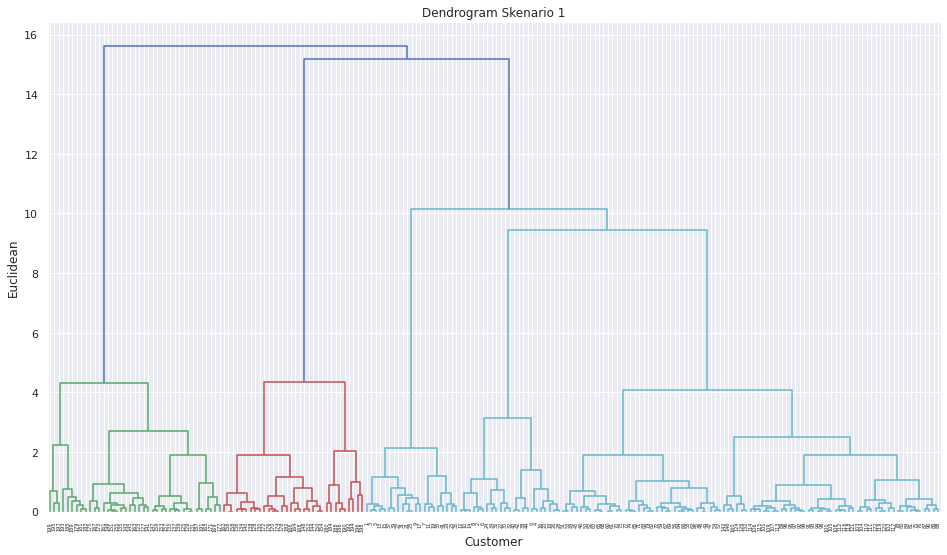

In [230]:
# Modeling and Visualizing Clusters by Dendogram
import scipy.cluster.hierarchy as sch
dend = sch.dendrogram(sch.linkage(income, method='ward'))
plt.title('Dendrogram Skenario 1')
plt.xlabel('Customer')
plt.ylabel('Euclidean')
plt.show()

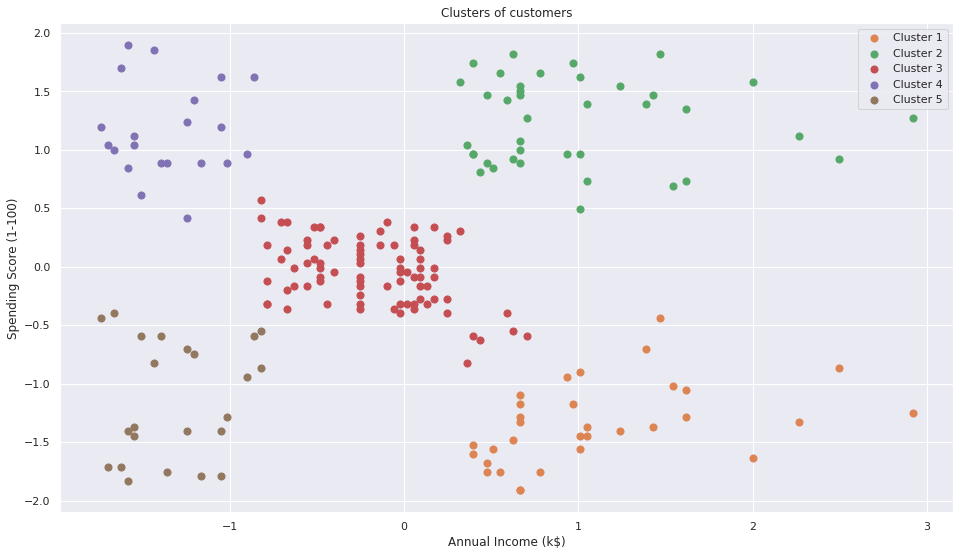

In [231]:
# Apply the Hierarchical Clustering Model to the Dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
hcluster = hc.fit_predict(income)

# Visualising Clusters for k=3
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=feautres_is)
plt.scatter(income[hcluster == 0, 0], income[hcluster == 0, 1], s = 50, label = 'Cluster 1')
plt.scatter(income[hcluster == 1, 0], income[hcluster == 1, 1], s = 50, label = 'Cluster 2')
plt.scatter(income[hcluster == 2, 0], income[hcluster == 2, 1], s = 50, label = 'Cluster 3')
plt.scatter(income[hcluster == 3, 0], income[hcluster == 3, 1], s = 50, label = 'Cluster 4')
plt.scatter(income[hcluster == 4, 0], income[hcluster == 4, 1], s = 50, label = 'Cluster 5')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

**Skenario 2**

Disini saya akan membuat visualisasi dendogram dari skenario 2.

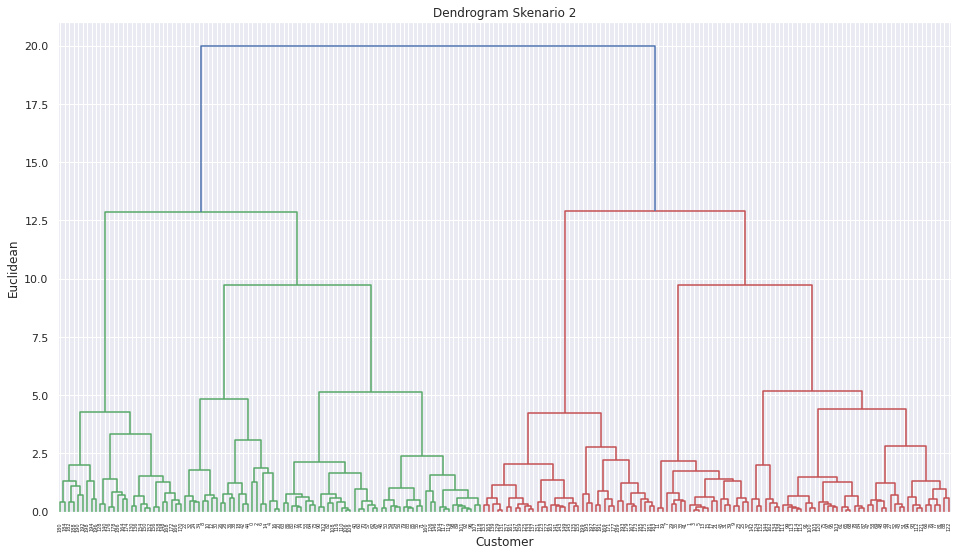

In [232]:
# Modeling and Visualizing Clusters by Dendogram
import scipy.cluster.hierarchy as sch
dend_3d = sch.dendrogram(sch.linkage(ftrs, method='ward'))
plt.title('Dendrogram Skenario 2')
plt.xlabel('Customer')
plt.ylabel('Euclidean')
plt.show()

## **Conclussion**

Berikut ini adalah pembagian banyaknya data pada tiap cluster pada tiap skenario

**Skenario 1**

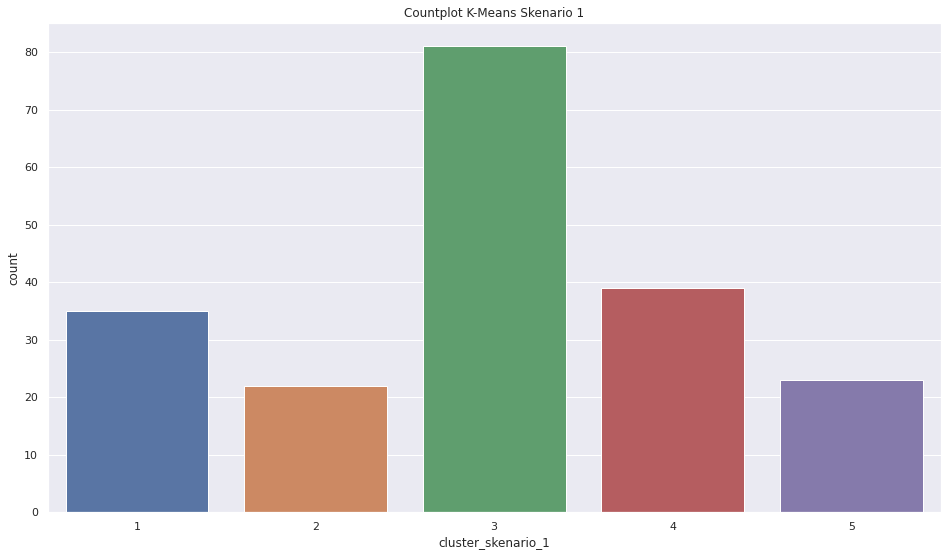

In [233]:
plt.figure(figsize=(16, 9))
plt.title('Countplot K-Means Skenario 1')
sns.countplot(x = df_mall['cluster_skenario_1'])
plt.show()

**Skenario 2**

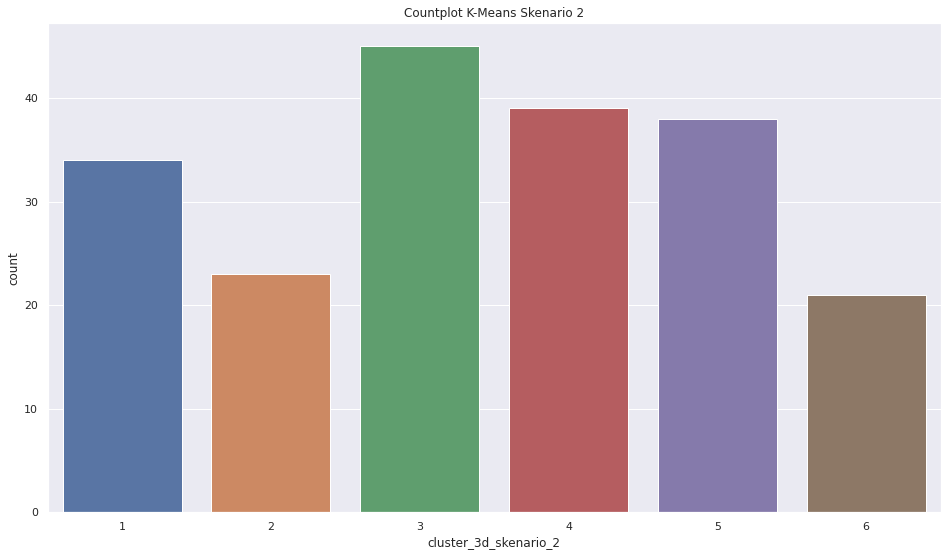

In [234]:
plt.figure(figsize=(16, 9))
plt.title('Countplot K-Means Skenario 2')
sns.countplot(x = df_mall['cluster_3d_skenario_2'])
plt.show()

Pada K-Means Clustering :

1.   Skenario 1 mempunyai nilai K optimum, yaitu K = 5, dimana nilai Silhoutte Coefficient-nya = 0.55,
2.   Skenario 2 mempunyai nilai K optimum, yaitu K = 6, dimana nilai Silhoutte Coefficient-nya = 0.43.